In [32]:
import sys

!{sys.executable} -m pip install datasets pybioclip ipywidgets chromadb --quiet

import torch
import datasets
from tqdm import tqdm
from bioclip.predict import BaseClassifier, TreeOfLifeClassifier
import chromadb
import PIL.Image
from IPython.display import display

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/bin/python -m pip install --upgrade pip


In [2]:
HF_DATASET = "Somnath01/Birds_Species"

In [15]:
clf = TreeOfLifeClassifier(device=device)
index_dataset = datasets.load_dataset(HF_DATASET, split='train', streaming=False)
test_dataset = datasets.load_dataset(HF_DATASET, split='test', streaming=False)

In [5]:
print(f"Size of the index dataset: {len(index_dataset)}")
print(f"Size of the test dataset: {len(test_dataset)}")

Size of the index dataset: 1000
Size of the test dataset: 403


For demo we will use a Ephemeral client which will persist the entire collection in memory

In [23]:
client = chromadb.Client()

collection = client.create_collection(
    name="bird_collection", 
    metadata={
        "hnsw:space": "cosine",
        "hnsw:search_ef": 10
    }
)

In [16]:
ids = list(map(lambda x: str(x), range(len(index_dataset))))

embeddings = list(
    map(
        lambda i: clf.create_image_features_for_image(index_dataset[i]["image"], 
                                                      normalize=True).tolist(),
        range(len(index_dataset))
    )
)

In [24]:
collection.add(embeddings=embeddings, ids=ids)
print(f"Number of embeddings added to the index: {collection.count()}")

Number of embeddings added to the index: 1000


### Query 

In [43]:
def get_neighbors(test_idx: int):
    query_img_embedding = clf.create_image_features_for_image(
        test_dataset[test_idx]["image"], normalize=True).tolist()
    
    return collection.query(query_embeddings=[query_img_embedding], 
                     n_results = 5)['ids']

In [50]:
def display_neighbors(test_idx: int):
    start_ts = datetime.now()
    neighbors = get_neighbors(test_idx)[0]
    end_ts = datetime.now()
    print("Below is the candidate image")
    display(test_dataset[test_idx]["image"])

    print("\nNearest neighbors")
    for neighbor in neighbors:
        display(index_dataset[int(neighbor)]["image"])

    print(f"Time taken: {end_ts - start_ts}")

Below is the candidate image


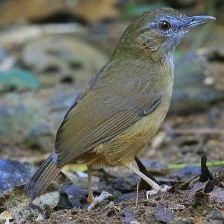


Nearest neighbors


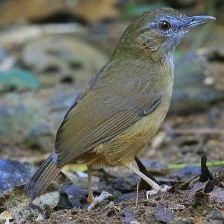

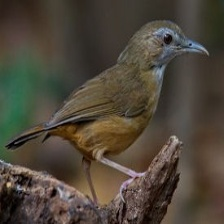

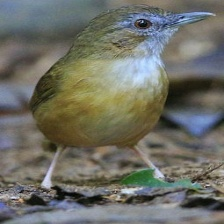

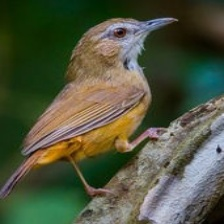

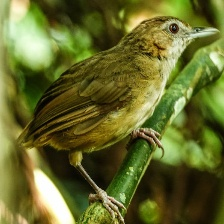

Time taken: 0:00:00.185136


In [51]:
display_neighbors(10)